In [37]:
import importlib
from src import extract, dataset, model
from pathlib import Path
import os 
import zipfile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import glob
import torch
import matplotlib.pyplot as plt


In [38]:
from src.model import SimpleUNet3D, train_model, evaluate_model, print_metrics

In [36]:
# Reloads modules (run for development update with the notebook)
importlib.reload(extract) 
importlib.reload(dataset)
importlib.reload(model)

<module 'src.model' from '/workspace/spine-score/src/model.py'>

In [55]:
# defaults to extracting from /workspaces/data
df = extract.extract_tsv_files()

# Assuming combined_df is your DataFrame
print(list(df.columns))

Combined DataFrame shape: (25389, 79)
['type', 'submitter_id', 'md5sum', 'file_size', 'file_name', 'data_type', 'data_format', 'data_category', 'annotation_name', 'annotation_method', 'cases.submitter_id', 'case_ids', 'mr_series_files.submitter_id', 'imaging_studies.submitter_id', 'urls', 'datasets', 'age_at_index', 'age_at_index_gt89', 'country_of_residence', 'covid19_positive', 'ethnicity', 'gen3_linked_subjects_available', 'icu_indicator', 'index_event', 'linked_external_data', 'long_covid_diagnosis', 'race', 'sex', 'site_id', 'token_record_id', 'ventilator_indicator', 'treatment_info', 'zip', 'acl', 'storage_urls', 'study_uid', 'series_uid', 'instance_uid', 'modality', 'datasets.submitter_id', 'body_part_examined', 'days_to_study', 'image_data_modified', 'study_description', 'study_modality', 'study_year', 'study_year_shifted', 'age_at_imaging', 'age_at_imaging_gt89', 'angio_flag', 'contrast_bolus_agent', 'diffusion_b_value', 'diffusion_gradient_orientation', 'echo_number', 'echo_t

In [ ]:
# extract data from the zip files downloaded
zip_path = "/workspace/data/DukeCSpineSeg_"
interim_dir = Path("/workspace/data/interim")

extract.extract_data(zip_path, interim_dir)

Files in /workspace/data/DukeCSpineSeg_segmentation.zip extracted.
Files in /workspace/data/DukeCSpineSeg_imaging_files.zip extracted.
Files in /workspace/data/DukeCSpineSeg_annotation.zip extracted.


In [ ]:
# Extract all .dcm files from their nested zips to help with data loading later
# root folder containing zip files 
root_dir = "/workspace/data/interim/imaging_files/case_image"

for dirpath, dirnames, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith(".zip"):
            zip_path = os.path.join(dirpath, file)
            # extract into the folder where the zip resides
            extract_to = dirpath
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"Extracted {zip_path} to {extract_to}")

Extracted /workspace/data/interim/imaging_files/case_image/593973-000001/1.2.826.0.1.3680043.10.474.593973.19/1.2.826.0.1.3680043.10.474.593973.20.zip to /workspace/data/interim/imaging_files/case_image/593973-000001/1.2.826.0.1.3680043.10.474.593973.19
Extracted /workspace/data/interim/imaging_files/case_image/593973-000001/1.2.826.0.1.3680043.10.474.593973.2/1.2.826.0.1.3680043.10.474.593973.3.zip to /workspace/data/interim/imaging_files/case_image/593973-000001/1.2.826.0.1.3680043.10.474.593973.2
Extracted /workspace/data/interim/imaging_files/case_image/593973-000003/1.2.826.0.1.3680043.10.474.593973.36/1.2.826.0.1.3680043.10.474.593973.37.zip to /workspace/data/interim/imaging_files/case_image/593973-000003/1.2.826.0.1.3680043.10.474.593973.36
Extracted /workspace/data/interim/imaging_files/case_image/593973-000004/1.2.826.0.1.3680043.10.474.593973.53/1.2.826.0.1.3680043.10.474.593973.54.zip to /workspace/data/interim/imaging_files/case_image/593973-000004/1.2.826.0.1.3680043.10.4

In [3]:
# Matching Study Ids to ensure that segmentation and images are mapped appropriately 
# DICOM root after extraction
dicom_root = "/workspace/data/interim/imaging_files/case_image"

# Segmentation root
mask_root = "/workspace/data/interim/segmentation"

# Map study_id -> DICOM folder
dicom_map = {}
for folder in glob.glob(os.path.join(dicom_root, "*")):  # first level
    study_id = os.path.basename(folder)
    # pick the deepest folder containing DICOMs
    dcm_subfolders = [f for f in glob.glob(os.path.join(folder, "**"), recursive=True) if os.path.isdir(f) and len(glob.glob(os.path.join(f, "*.dcm"))) > 0]
    if dcm_subfolders:
        dicom_map[study_id] = dcm_subfolders[0]
        
# Map study_id -> mask file
mask_map = {}
for mask_file in glob.glob(os.path.join(mask_root, "*_SEG.nii.gz")):
    study_id = os.path.basename(mask_file).split("_")[0]
    mask_map[study_id] = mask_file

# Only keep the studies that have both DICOMs and masks
dataset_entries = [(dicom_map[s], mask_map[s]) for s in dicom_map if s in mask_map]

print(f"Found {len(dataset_entries)} paired DICOMs and masks")
print(f"Example entry: {dataset_entries[0]}")

Found 1231 paired DICOMs and masks
Example entry: ('/workspace/data/interim/imaging_files/case_image/593973-000001/1.2.826.0.1.3680043.10.474.593973.19/1.2.826.0.1.3680043.10.474.593973.20', '/workspace/data/interim/segmentation/593973-000001_Study-MR-1_Series-22_SEG.nii.gz')


In [4]:
from sklearn.model_selection import train_test_split

# dataset_entries already built earlier
print("Total samples:", len(dataset_entries))

# First split: train + temp (val+test)
train_entries, temp_entries = train_test_split(
    dataset_entries, test_size=0.3, random_state=42
)

# Second split: val + test
val_entries, test_entries = train_test_split(
    temp_entries, test_size=0.5, random_state=42
)

print(f"Train 70%: {len(train_entries)}")
print(f"Val 15%:   {len(val_entries)}")
print(f"Test 15%:  {len(test_entries)}")


Total samples: 1231
Train 70%: 861
Val 15%:   185
Test 15%:  185


In [5]:
target_shape = (1, 224, 224, 48)  # divisible by 16 (if UNet has 4 downsamplings)
target_spacing=(1.0,1.0,1.0)

# Creating a dataset objects that knows how to load DICOM volumes + NIfTI masks one sample at a time
train_dataset = dataset.SpineSegDataset(train_entries, target_shape=target_shape, target_spacing=target_spacing)
val_dataset   = dataset.SpineSegDataset(val_entries, target_shape=target_shape, target_spacing=target_spacing)
test_dataset  = dataset.SpineSegDataset(test_entries, target_shape=target_shape, target_spacing=target_spacing)

# Wraps dataset into an iterable loader that handles batching + shuffling
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)

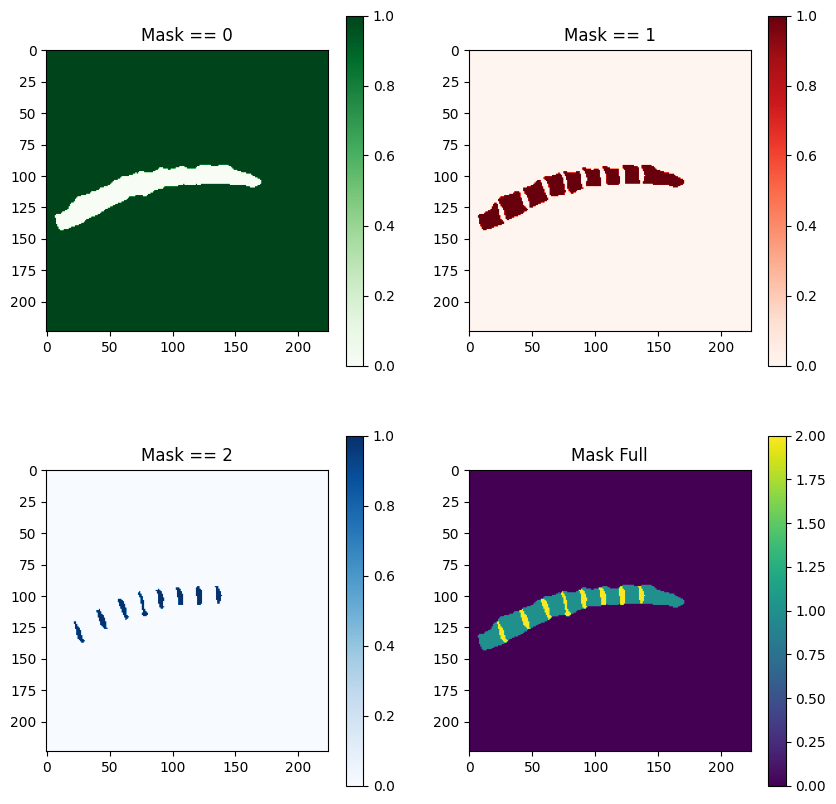

In [44]:
vol, msk = next(iter(train_loader))

# msk shape: (1, H, W, D)
mid = msk.shape[-1] // 2   # mid slice along depth

plt.figure(figsize=(10,10))

# Class 0
plt.subplot(2,2,1)
plt.title("Mask == 0")
plt.imshow((msk[0,:,:,mid] == 0).cpu(), cmap="Greens")
plt.colorbar()

# Class 1
plt.subplot(2,2,2)
plt.title("Mask == 1")
plt.imshow((msk[0,:,: ,mid] == 1).cpu(), cmap="Reds")
plt.colorbar()

# Class 2
plt.subplot(2,2,3)
plt.title("Mask == 2")
plt.imshow((msk[0,:,: ,mid] == 2).cpu(), cmap="Blues")
plt.colorbar()

# All labels
plt.subplot(2,2,4)
plt.title("Mask Full")
plt.imshow(msk[0,:,:,mid].cpu(), cmap="viridis")
plt.colorbar()

plt.show()


In [6]:
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

print(f"Train sample shapes: \nVolume: {train_batch[0].shape}, Mask: {train_batch[1].shape}")
print(f"Val sample shapes: \nVolume: {val_batch[0].shape}, Mask: {val_batch[1].shape}")
print(f"Test sample shapes: \nVolume: {test_batch[0].shape}, Mask: {test_batch[1].shape}")
print("Unique mask labels:", torch.unique(test_batch[1]))


Train sample shapes: 
Volume: torch.Size([1, 1, 224, 224, 48]), Mask: torch.Size([1, 224, 224, 48])
Val sample shapes: 
Volume: torch.Size([1, 1, 224, 224, 48]), Mask: torch.Size([1, 224, 224, 48])
Test sample shapes: 
Volume: torch.Size([1, 1, 224, 224, 48]), Mask: torch.Size([1, 224, 224, 48])
Unique mask labels: tensor([0, 1, 2])


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_UNet = SimpleUNet3D(in_channels=1, out_channels=3)
model_UNet, history = train_model(model_UNet, train_loader, val_loader, device, num_epochs=2, num_classes=3)

Epoch 1/2:   0%|          | 0/861 [00:00<?, ?it/s]

In [24]:
from torch.utils.data import Subset, DataLoader

# Keep only the first 5 samples for a quick test
small_train_dataset = Subset(train_dataset, range(5))
small_train_loader = DataLoader(small_train_dataset, batch_size=1, shuffle=True)

# Similarly for validation
small_val_dataset = Subset(val_dataset, range(5))
small_val_loader = DataLoader(small_val_dataset, batch_size=1, shuffle=False)

# Similarly for test
small_test_dataset = Subset(test_dataset, range(5))
small_test_loader = DataLoader(small_test_dataset, batch_size=1, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_UNet = SimpleUNet3D(in_channels=1, out_channels=3)
model_UNet, history = train_model(model_UNet, small_train_loader, small_val_loader, device, num_epochs=2, num_classes=3)

Epoch [1/2] Train Loss: 1.6872 Val Loss: 1.8406 Val Dice: 0.2470


Epoch [2/2] Train Loss: 1.3961 Val Loss: 1.5252 Val Dice: 0.3003


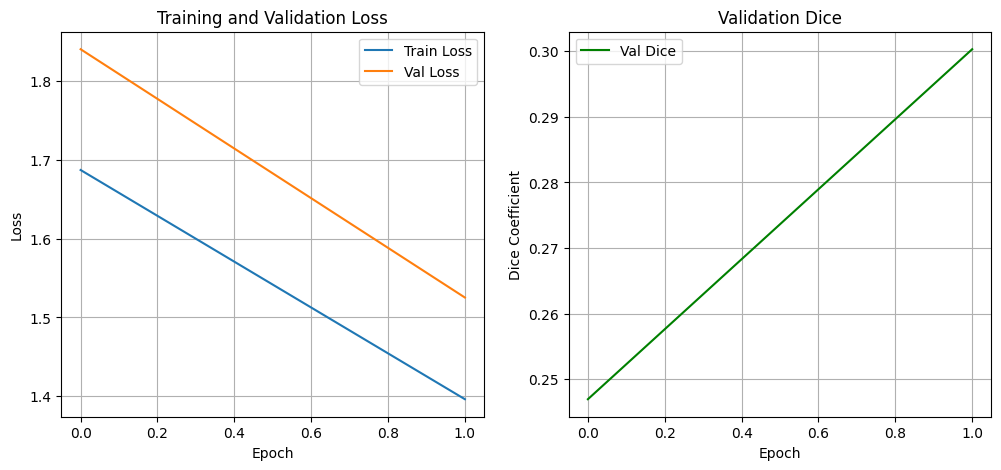

In [ ]:
# Plot Loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Dice curves (validation only)
plt.subplot(1,2,2)
plt.plot(history['val_dice'], label='Val Dice', color='green')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Validation Dice')
plt.legend()
plt.grid(True)

plt.show()


In [29]:
mean_dice, class_dice, metrics = evaluate_model(model_UNet, small_test_loader, device, num_classes=3)

print(f"Overall mean Dice: {mean_dice:.4f}")
for i, d in enumerate(class_dice):
    print(f"Class {i} Dice: {d:.4f}")

Overall mean Dice: 0.2973
Class 0 Dice: 0.8554
Class 1 Dice: 0.0305
Class 2 Dice: 0.0061


In [45]:
class_names = ["Background", "Vertebrae", "Intervertebral Discs"]

print_metrics(metrics, class_names)


===== Evaluation Metrics per Class =====

               Class  Accuracy  Precision  Recall  F1 Score
          Background    0.7440     0.9747  0.7574    0.8524
           Vertebrae    0.7869     0.0183  0.1875    0.0334
Intervertebral Discs    0.9549     0.0006  0.0053    0.0010




In [ ]:
# Save
torch.save(model_UNet.state_dict(), "/workspace/weights/unet3d_weights_v1.1.pth")

# Load if needed
# model_UNet = SimpleUNet3D(in_channels=1, out_channels=3)  # same architecture
# model_UNet.load_state_dict(torch.load("pathTo.pth"))
# model_UNet.to(device)
# model_UNet.eval()  # set to evaluation mode if testing

In [ ]:
# Delete model and optimizer references (optional if you don't need them)
del model_UNet

# Clear CUDA cache
torch.cuda.empty_cache()

# Optional: collect Python garbage
import gc
gc.collect()